# Implementacja PWC-Net w tensorflow
Poniższy notebook prezentuje implementację [PWC-Net](https://arxiv.org/abs/1709.02371) w tensorflow. Niestety, rozmiar potrzebnych do wytrenowania sieci danych okazał się zbyt duży do skutecznego nauczenia sieci w Google Colab, przez co sieć uczy się tylko na małym podzbiorze zbioru FlyingChairs, przez co wyniki znacznie odbiegają od tych uzyskanych przez autorów.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
# %cd /content/drive/MyDrive/edu/datasets/
# !pwd
# !wget https://lmb.informatik.uni-freiburg.de/data/FlyingChairs/FlyingChairs.zip

In [ ]:
!pip install tensorflow-addons
!pip install scipy
!pip install -q pyyaml h5py

In [ ]:
%matplotlib inline
import os
import glob
import struct
from zipfile import ZipFile

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, LeakyReLU, Concatenate, Add, Conv2DTranspose, Lambda
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons.image.dense_image_warp as dense_image_warp
from PIL import Image
os.getcwd()

'/content/drive/My Drive'

In [ ]:
%cd /content/drive/MyDrive
# os.listdir()
# !unzip FlyingChairs_release.zip
# %cd ..
# os.getcwd()

/content/drive/MyDrive


(384, 512, 3) (384, 512, 3)
(1, 384, 512, 3) (1, 384, 512, 3)


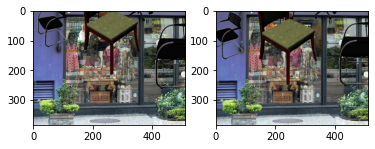

In [ ]:
import imageio
data_dir = os.path.join(os.getcwd(), 'data', 'FlyingChairs_release', 'data')
img_1 = imageio.imread(os.path.join(data_dir, 'img1', 'images', '05758_img1.ppm'))
img_2 = imageio.imread(os.path.join(data_dir, 'img2', 'images', '05758_img2.ppm'))
# os.listdir(img_1_dir)[:10], os.listdir(img_2_dir)[:10]
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(img_1)
axarr[1].imshow(img_2)
print(img_1.shape, img_2.shape)
img_1 = np.expand_dims(img_1, 0)
img_2 = np.expand_dims(img_2, 0)
img_1_tensor = tf.convert_to_tensor(img_1)
img_2_tensor = tf.convert_to_tensor(img_2)
print(img_1.shape, img_2.shape)

In [ ]:
cost_v = cost_volume(img_1_tensor, img_2_tensor)
print(cost_v.shape)

(1, 384, 512, 25)


In [ ]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
seed = 1337
RANDOM_STATE = np.random.RandomState(seed)

In [ ]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
#     assert img.shape[2] == 3
    print(img)
    _, height, width, _ = img.shape
    dy, dx = random_crop_size
    print(height, dy)
    x = RANDOM_STATE.randint(0, width - dx + 1)
    y = RANDOM_STATE.randint(0, height - dy + 1)
    return img[:, y:(y+dy), x:(x+dx), :]

In [ ]:
batch_size = 8
validation_split = 0.2
datagen_opt = {
    'target_size' : (384, 512),
    'batch_size' : batch_size,
    'seed' : seed,
    'class_mode' : None
}
crop_w = 384
crop_h = 448
augment_opt = { 
    
}

# data_dir = os.path.join(os.getcwd(), 'edu', 'datasets', 'FlyingChairs_release', 'data')
img_1_dir = os.path.join(data_dir, 'img1')
img_2_dir = os.path.join(data_dir, 'img2')
flo_dir = os.path.join(data_dir, 'flow', 'flows')
flo_files = os.path.join(data_dir, 'flow', 'flows', '*.flo')
DATASET_SIZE = len(os.listdir(flo_dir))
# DATASET_SIZE = 22830

print(DATASET_SIZE)
img1_gen = ImageDataGenerator(**augment_opt)
img2_gen = ImageDataGenerator(**augment_opt)

img1_dataset = tf.data.Dataset.from_generator(lambda: img1_gen.flow_from_directory(img_1_dir, **datagen_opt), 
                                              output_signature=(tf.TensorSpec(shape=(batch_size, 384, 512,3), dtype=tf.float32)))
img2_dataset = tf.data.Dataset.from_generator(lambda: img1_gen.flow_from_directory(img_2_dir, **datagen_opt), 
                                              output_signature=(tf.TensorSpec(shape=(batch_size, 384, 512,3), dtype=tf.float32)))

img_dataset = tf.data.Dataset.zip((img1_dataset, img2_dataset))

flo_dataset = tf.data.Dataset.list_files(flo_files, shuffle=True, seed=seed).map(tf.io.read_file).batch(batch_size)

dataset = tf.data.Dataset.zip((img_dataset, flo_dataset))
train_dataset = dataset.take(int((1-validation_split) * DATASET_SIZE / batch_size))
val_dataset = dataset.skip(int((1-validation_split) * DATASET_SIZE / batch_size))

1049


In [ ]:
# train_size = 0
# # val_size = 0
# # for batch in val_dataset.take(10):
# #   train_size += 1
# for step, ((img1, img2), flo) in enumerate(train_dataset):
#   if not step % 20:
#     print(img1.shape)
#     print(img2.shape)
#     print(flo.shape)
#     print(f'Step {step}')
#   train_size += 1
# # # for batch in val_dataset.take(1):
# # #   val_size += 1

# train_size

Poniższa komórka implementuje blok piramidowego ekstraktora cech 

In [ ]:
class PyramidBlock(Layer):
    
    
    def __init__(self, filters : int, kernel_size=3, kernel_regularizer='l2'):
        super(PyramidBlock, self).__init__()
        init = tf.keras.initializers.he_normal()
        self.downsample = Conv2D(filters, kernel_size,
                                 strides=2, padding='same',
                                 activation=LeakyReLU(alpha=0.1), kernel_regularizer=kernel_regularizer,
                                 kernel_initializer=init)
        
        self.conv = Conv2D(filters, kernel_size, padding='same',
                           activation=LeakyReLU(alpha=0.1), kernel_regularizer=kernel_regularizer,
                           kernel_initializer=init)
        
        self.ext_feat = Conv2D(filters, kernel_size, padding='same',
                               activation=LeakyReLU(alpha=0.1), kernel_regularizer=kernel_regularizer,
                               kernel_initializer=init)
        
    def call(self, inputs):
        x = self.downsample(inputs)
        x = self.conv(x)
        return self.ext_feat(x)
        

class FeatureExtractor(Layer):
    
    
    def __init__(self, pyr_levels=6, kernel_regularizer='l2'):
        super(FeatureExtractor, self).__init__()
        self.pyr_levels = pyr_levels
        filters = [16, 32, 64, 96, 128, 192]
        self.pyr = []
        
        init = tf.keras.initializers.he_normal()
        for i in range(pyr_levels):
            self.pyr.append(PyramidBlock(filters=filters[i], kernel_regularizer=kernel_regularizer))
            
    def call(self, im1, im2):
        x1, x2 = im1, im2
        pyr = []
        for i in range(self.pyr_levels):
            x1 = self.pyr[i](x1)
            x2 = self.pyr[i](x2)
            pyr.append((x1, x2))
        return pyr[::-1]

Poniżej implementacja funkcji kosztu dopasowań

In [ ]:
# @tf.function(experimental_relax_shapes=True)
def cost_volume(c1, warp, search_range=2):
    """Build cost volume for associating a pixel from Image1 with its corresponding pixels in Image2.
    Args:
        c1: Level of the feature pyramid of Image1
        warp: Warped level of the feature pyramid of image22
        search_range: Search range (maximum displacement)
    """
    # with tf.device('CPU'):
    # print(f'C1 shape: {c1.shape}')
    # print(f'Warp shape: {warp.shape}')
    padded_lvl = tf.pad(warp, [[0, 0], [search_range, search_range], [search_range, search_range], [0, 0]]) # pad only h and w
    _, h, w, _ = tf.unstack(tf.shape(c1))
    # print(padded_lvl.shape)
    max_offset = search_range * 2 + 1

    cost_vol = []
    # print(f'Padded lvl shape: {padded_lvl.shape}')
    for y in range(0, max_offset):
        for x in range(0, max_offset):
            slice_ = tf.slice(padded_lvl, [0, y, x, 0], [-1, h, w, -1])
            # print(f'Slice shape: {slice_.shape}')
            cost = tf.reduce_mean(c1 * slice_, axis=3, keepdims=True)
            # print(cost.shape)
            cost_vol.append(cost)
    # print(np.array(cost_vol).shape)
    cv = tf.concat(cost_vol, axis=3)
    cost_vol = tf.concat(cost_vol, axis=-1)
    tf.debugging.assert_equal(cv, cost_vol)
    # print(f'Cost volume shape: {cost_vol.shape}')
    cost_vol = tf.nn.leaky_relu(cost_vol, alpha=0.1)
    return cost_vol

Część sieci odpowiedzialna za samo wyznaczanie przepływu

In [ ]:
class FlowPredictor(Layer):
    
    
    def __init__(self, kernel_regularizer='l2'):
        super(FlowPredictor, self).__init__()
        filters = [128,128,96,64,32]
        self.flow_est = []
        init = tf.keras.initializers.he_normal()
        for f in filters:
            self.flow_est.append(Conv2D(f, 3, padding='same', 
                                        activation=LeakyReLU(alpha=0.1), kernel_regularizer=kernel_regularizer, kernel_initializer=init))
        self.flow_out = Conv2D(2, 3, padding='same', kernel_regularizer=kernel_regularizer, kernel_initializer=init)
            
        
        
        
    def call(self, corr, c1, upflow, upfeat):
        """
        Args:
            corr: The cost volume at level lvl
            c1: The level of the feature pyramid of Image1
            up_flow: An upsampled version of the predicted flow from the previous level
            up_feat: An upsampled version of the features that were used to generate the flow prediction
        """
        
        if c1 is None and upflow is None and upfeat is None: # highest level
            x = corr
        else:
            x = tf.concat([corr, c1, upflow, upfeat], axis=3)
        for conv in self.flow_est:
            x = conv(x)
        return x, self.flow_out(x)

Funkcja obliczająca zniekształcenie obrazu na podstawie wyznaczonego przepływu

In [ ]:
@tf.function(experimental_relax_shapes=True)
def warp(im, flow):
  # print(f'Im shape {im.shape}')
  # print(f'Flow shape {flow.shape}')
  warped = dense_image_warp(im, flow)
  # print(f'Warp shape {warped.shape}')
  return warped

Dylatacyjna sieć kontekstowa mająca na celu wykorzystanie informacji o kontekście w celu dalszego poprawienia pola przepływu

In [ ]:
class ContextNetwork(Layer):
    
    def __init__(self, kernel_regularizer='l2'):
        super(ContextNetwork, self).__init__()
        filters = [128, 128, 128, 96, 64, 32]
        dilations = [1, 2, 4, 8, 16, 1]
        self.net = []
        init = tf.keras.initializers.he_normal()
        for f, d in zip(filters, dilations):
            self.net.append(Conv2D(f, 3,
                                   padding='same', dilation_rate=d,
                                   activation=LeakyReLU(alpha=0.1), kernel_regularizer=kernel_regularizer, kernel_initializer=init))
        self.out = Conv2D(2, kernel_size=3, padding='same', kernel_regularizer=kernel_regularizer, kernel_initializer=init)
        self.add = Add()
        
    def call(self, feat, flo):
        x = feat
        for block in self.net:
            x = block(x)
        return self.add((flo, self.out(x)))
        

In [ ]:
class PWCNet(tf.keras.Model):
    
    
    def __init__(self, pyr_levels=6, use_context=True, kernel_regularizer='l2'):
        super(PWCNet, self).__init__()
        self.pyr_levels = pyr_levels
        self.scales = [None, 0.625, 1.25, 2.5, 5.0, 10.0]
        self.use_context = use_context
        self.feat_pyr_extractor = FeatureExtractor(kernel_regularizer=kernel_regularizer)
        self.cost_volume = Lambda(lambda inp : cost_volume(inp[0], inp[1]), name='cost_volume')
        self.flow_predictors = [FlowPredictor(kernel_regularizer=kernel_regularizer) for _ in range(pyr_levels)]
        self.warp = Lambda(lambda inp : dense_image_warp(inp[0], inp[1]), name='warp')
        self.context_net = ContextNetwork(kernel_regularizer=kernel_regularizer)
        self.feat_upsamplers = [Conv2DTranspose(2, 4, strides=2, padding='same', kernel_regularizer=kernel_regularizer)
                                for _ in range(pyr_levels - 1)]
        self.flo_upsamplers = [Conv2DTranspose(2, 4, strides=2, padding='same', kernel_regularizer=kernel_regularizer)
                               for _ in range(pyr_levels - 1)]
        
    def call(self, inputs):
        im1, im2 = inputs
        # print(f'(Im1 shape: {im1.shape}, Im2 shape: {im2.shape}')
        pyr = self.feat_pyr_extractor(im1, im2)
        # for p in pyr:
        #   print(p[0].shape)
        #   print(p[1].shape)
        flow_pyr = []
        for lvl, scale in enumerate(self.scales):
            x1 = pyr[lvl][0]
            x2 = pyr[lvl][1]
            if lvl == 0:
                corr = self.cost_volume((x1, x2))
                upfeat, flow = self.flow_predictors[lvl](corr, None, None, None)
            else:
                # print(f'X2 shape: {x2.shape}')
                warped = self.warp((x2, upflow*scale))
                corr = self.cost_volume((x1, warped))
                upfeat, flow = self.flow_predictors[lvl](corr, x1, upflow, up_feat)
            if lvl != self.pyr_levels - 1:
                if self.use_context:
                    flow = self.context_net(upfeat, flow)
                flow_pyr.append(flow)
                up_feat = self.feat_upsamplers[lvl](upfeat)
                upflow = self.flo_upsamplers[lvl](flow)
            else: # final level
                flow = self.context_net(upfeat, flow)
                flow_pyr.append(flow)
                _, h, w, _ = tf.unstack(x1.shape)
                scaler = 2
                size = (h * scaler, w * scaler)
                flow_pred = tf.image.resize(flow, size) * scaler

        # print(f'flow pred shape {flow_pred.shape}. flow_pyr_len: {len(flow_pyr)}')
        # print(f'Flow pyr shapes: {[pyr.shape for pyr in flow_pyr]}')
        # print('Call over')
        flow_pyr.reverse()     
        return flow_pred, flow_pyr
            
        

In [ ]:
class Loss:

    __name__ = 'PWC_Net_Loss'
    
    
    def __init__(self, q=1, eps=0, norm_order=2, alphas=(.32, .08, .02, .01, .005), gamma=.0004):
        self.q = q
        self.eps = eps
        self.norm_order = norm_order
        self.alphas = alphas
        self.gamma = gamma
        
    def loss(self, y_true, y_hat_pyr):
      total_loss = 0
      _, gt_h, _, _ = tf.unstack(y_true.shape)

      for y, alpha in zip(y_hat_pyr, self.alphas):
        # print(y.shape)
        _, lvl_h, lvl_w, _ = tf.unstack(y.shape)

        scaled_gt = tf.image.resize(y_true, (lvl_h, lvl_w))
        scaled_gt /= tf.cast(gt_h / lvl_h, dtype=tf.float32)

        norm = tf.norm(scaled_gt - y, ord=self.norm_order, axis=3)
        lvl_loss = tf.reduce_mean(tf.reduce_sum(norm, axis=(1, 2)))

        total_loss += alpha * tf.pow(lvl_loss + self.eps, self.q)
      return total_loss
    
    def __call__(self, y_true, y_hat_pyr):
        return self.loss(y_true, y_hat_pyr)

In [ ]:
def scheduler(iters : int):
    if epoch < 4e5:
        return 0.0001
    elif 4e5 <= epoch < 6e5:
        return 0.00005
    elif 6e5 <= epoch < 8e5:
        return 0.000025
    elif 8e5 <= epoch < 1e6:
        return 0.0000125
    else:
        return 0.00000625

In [ ]:
def decode_flo_batch(bytes_, batch_size, verbose=False):
    """
    Read from .flo optical flow file (Middlebury format)
    :param flow_file: name of the flow file
    :return: optical flow data in matrix
    
    adapted from https://github.com/liruoteng/OpticalFlowToolkit/
    
    """

    f = tf.io.decode_raw(bytes_, out_type=tf.float32).numpy()
    magic = f[:, 0]
    data2d = None

    if np.any(202021.25 != magic):
        raise TypeError('Magic number incorrect. Invalid .flo file')
    else:
      w = np.frombuffer(f[:, 1].tobytes(), dtype=np.int32)
      h = np.frombuffer(f[:, 2].tobytes(), dtype=np.int32)
    data_batch = f[:, 3:]
    if verbose:
      print(f"Reading {h} x {w} flow file in .flo format")
    # data2d = np.fromfile(f, np.float32, count=int(2 * w * h))
    # reshape data into 3D array (columns, rows, channels)
    assert np.all(h == h[0]) and np.all(w == w[0]), \
     f'Some flo files are wrong size. Batch sizes: {h} x {w} '
    data2d = np.resize(data_batch, (batch_size, h[0], w[0], 2))
    # print(f'numpy shape: {data2d.shape}')
    # data2d = tf.image.resize(data_batch, (batch_size, h[0], w[0], 2))
    # print(f'tf shape: {data2d.shape}')
    return tf.convert_to_tensor(data2d)


def create_dir_if_not_exists(directory : str):
    if not os.path.exists(directory):
        os.makedirs(directory)
    

def restructure_flying_chair_dir(data_dir : str):
    img_1_dir = os.path.join(data_dir, 'img1', 'images')
    img_2_dir = os.path.join(data_dir, 'img2', 'images')
    flo_dir = os.path.join(data_dir, 'flow', 'flows')
    create_dir_if_not_exists(img_1_dir)
    create_dir_if_not_exists(img_2_dir)
    create_dir_if_not_exists(flo_dir)
    
    # print(os.listdir(data_dir)[:3])
    for f in os.listdir(data_dir):
        if f.endswith('img1.ppm'):
            os.rename(os.path.join(data_dir, f), (os.path.join(img_1_dir, f)))
        elif f.endswith('img2.ppm'):
            os.rename(os.path.join(data_dir, f), (os.path.join(img_2_dir, f)))
        elif f.endswith('flo'):
            os.rename(os.path.join(data_dir, f), (os.path.join(flo_dir, f)))

In [ ]:
# file = os.path.join(flo_dir, os.listdir(flo_dir)[0])
# print(file)
# test_flo_batch = tf.expand_dims(tf.io.read_file(file), 0)
# print(type(test_flo_batch))
# print(test_flo_batch.shape)
# decode_flo_batch(test_flo_batch, 1)

In [ ]:
model = PWCNet(use_context=False)
loss_ = Loss()
optimizer = tf.keras.optimizers.Adam()
# optimizer.apply_gradients(
#     (grad, var) 
#     for (grad, var) in zip(gradients, model.trainable_variables) 
#     if grad is not None
# )
lrs = LearningRateScheduler(scheduler)
# model.compile(loss=[lambda y_true,y_hat: 1., loss_], loss_weights=[0.0, 1.0], optimizer=optimizer)
# model.build(input_shape=)

In [ ]:
train_mse_metric = tf.keras.metrics.RootMeanSquaredError()
val_mse_metric = tf.keras.metrics.RootMeanSquaredError()

@tf.function
def train_step(im1, im2, flo):
  with tf.GradientTape() as tape:
    train_flo, flo_pyr = model((im1, im2))
    loss_val = loss_(flo, flo_pyr)
  grads = tape.gradient(loss_val, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  train_mse_metric.update_state(flo, train_flo)
  return loss_val

@tf.function
def test_step(im1, im2, flo):
    val_flo, _ = model((im1, im2), training=False)
    val_mse_metric.update_state(flo, val_flo)

In [ ]:
# from datetime import datetime
epochs = 100
prev_time =  datetime.now()
prev_mse = float('inf')

for epoch in range(epochs):
  iters = epoch * (DATASET_SIZE / batch_size) # + step
  lr = scheduler(iters)
  optimizer.lr = lr
  for step, ((im1, im2), flo_bytes) in enumerate(train_dataset):
    flo = decode_flo_batch(flo_bytes, batch_size=batch_size)
    # print(type(im1))
    # print(type(im2))
    # print(type(flo))
    loss_val = train_step(im1, im2, flo)
    # with tf.GradientTape() as tape:
    #   train_flo, flo_pyr = model((im1, im2), training=True)
    #   loss_val = loss_(flo, flo_pyr)
    # grads = tape.gradient(loss_val, model.trainable_weights)
    # optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # train_mse_metric.update_state(flo, train_flo)
    if step % 50 == 0:
      print(f'Steps took {datetime.now() - prev_time}')
      prev_time = datetime.now()
      print(f"Training loss (for one batch) at step {step}: {float(loss_val)}")
      train_mse = train_mse_metric.result()
      print(f'Avg endpoint error at step {step}: {float(train_mse)}')
      train_mse_metric.reset_states()
      print(f"Seen so far: {((step + 1) * batch_size)} samples")

      # for (im1, im2), flo_bytes in val_dataset:
      #   flo = decode_flo_batch(flo_bytes, batch_size=batch_size)
      #   test_step(im1, im2, flo)

      # val_mse = float(val_mse_metric.result())
      # val_mse_metric.reset_states()

      # print(f"Validation acc: {val_mse:.4f}")

      # if val_mse < prev_mse:
      #   prev_mse = val_mse
      #   model.save_weights('/content/drive/MyDrive/edu/checkpoints/pwc_net_weights')
  
  model.save_weights('/content/drive/MyDrive/edu/checkpoints/pwc_net_weights')
  # for (im1, im2), flo_bytes in val_dataset:
  #   flo = decode_flo_batch(flo_bytes, batch_size=batch_size)
  #   test_step(im1, im2, flo)

  # val_mse = float(val_mse_metric.result())
  # val_mse_metric.reset_states()

  # print(f"Validation acc: {val_mse:.4f}") 

  # if val_mse < prev_mse:
  #   prev_mse = val_mse
  #   model.save_weights('/content/drive/MyDrive/edu/checkpoints/pwc_net_weights')


Found 1049 images belonging to 1 classes.
Found 1049 images belonging to 1 classes.
Steps took 0:00:12.751576
Training loss (for one batch) at step 0: 126759224.0
Avg endpoint error at step 0: 14258.37890625
Seen so far: 8 samples
Steps took 0:00:47.141836
Training loss (for one batch) at step 50: 12173308.0
Avg endpoint error at step 50: 1774.238525390625
Seen so far: 408 samples
Steps took 0:00:45.226161
Training loss (for one batch) at step 100: 7799272.5
Avg endpoint error at step 100: 296.3240661621094
Seen so far: 808 samples
Found 1049 images belonging to 1 classes.
Found 1049 images belonging to 1 classes.
Steps took 0:00:04.395116
Training loss (for one batch) at step 0: 10754757.0
Avg endpoint error at step 0: 192.48681640625
Seen so far: 8 samples
Steps took 0:00:47.880502
Training loss (for one batch) at step 50: 4955304.0
Avg endpoint error at step 50: 160.64700317382812
Seen so far: 408 samples
Steps took 0:00:46.568807
Training loss (for one batch) at step 100: 5528293.5